### library import

In [24]:
import numpy as np
import scipy.misc as scm
import math
import random

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

### modelingクラス

In [25]:
class Modeling:

    def __init__(self,lambda_poisson, repeat, weight):
        self.lambda_poisson = lambda_poisson
        self.collecting_deadline = lambda_poisson * 2
        self.repeat = repeat
        self.poisson = np.random.poisson(lambda_poisson, 1000)
        self.weight = float(weight)

    def half_num(self,num):
        return int(math.ceil(float(num) / 2))

    def simulate_when_people_come_list(self, people_num):
        when_people_come = [0] * self.collecting_deadline
        for t in range(people_num):
            when_people_come[t] = 1
        random.shuffle(when_people_come)
        return when_people_come

    def relative_error_by_majority_vote(self, people_num, possibility_correct):
        half_num = self.half_num(people_num)
        relative_error = 0
        for t in range(half_num):
            relative_error += (possibility_correct**t) * ((1 - possibility_correct)**(people_num - t)) * scm.comb(people_num, t)
        return relative_error

    def relative_error_array_by_half_opinion(self, finish_num, possibility_correct):
        relative_error = []
        for t in range(finish_num):
            relative_error.append(((1 - possibility_correct)**finish_num) * (possibility_correct**t) * scm.comb(finish_num - 1 + t, t))
        return relative_error

    def deciding_by_first_person_with_poisson(self, possibility_correct):
        temp_method_utility = 0
        for n in range(self.repeat):
            people_num = self.poisson[n] # ポアソン分布したがって来る人数
            when_people_come = self.simulate_when_people_come_list(people_num)
            method_utility = 0
            for i in range(len(when_people_come)):
                if when_people_come[i] == 0: continue
                method_utility += possibility_correct - self.weight * (float(i) / self.collecting_deadline)
                break
            temp_method_utility += method_utility
        average_method_utility = temp_method_utility / self.repeat
        return average_method_utility

    def deciding_by_majority_vote_with_poisson(self, possibility_correct, majority_vote_people):
        temp_method_utility = 0
        for n in range(self.repeat):
            people_num = self.poisson[n]
            when_people_come = self.simulate_when_people_come_list(people_num)
            method_utility = 0
            people_count = 0
            if people_num < majority_vote_people: continue
            for i in range(len(when_people_come)):
                if when_people_come[i] == 0: continue
                people_count += 1
                if people_count == majority_vote_people:
                    method_utility += (1 - self.relative_error_by_majority_vote(people_count, possibility_correct)) - self.weight * (float(i) / self.collecting_deadline)
                    break
            temp_method_utility += method_utility
        average_method_utility = temp_method_utility / self.repeat
        return average_method_utility

    def deciding_by_half_opinion_with_poisson(self, possibility_correct, temp_people_num):
        temp_method_utility = 0
        for n in range(self.repeat):
            people_num = self.poisson[n]
            when_people_come = self.simulate_when_people_come_list(people_num)
            method_utility = 0
            people_count = 0
            people_count_arr = []
            if people_num < temp_people_num: continue
            for i in range(len(when_people_come)):
                if when_people_come[i] == 0: continue
                people_count_arr.append(i)
                people_count += 1
                if people_count == temp_people_num:
                    relative_error_array = self.relative_error_array_by_half_opinion(self.half_num(temp_people_num), possibility_correct)
                    expected_error = sum(relative_error_array)
                    average_index = 0
                    for index in range(len(relative_error_array)):
                        average_index += people_count_arr[self.half_num(temp_people_num) - 1 + index] * (relative_error_array[index] / expected_error)
                    method_utility = (1 - expected_error) - self.weight * (float(average_index) / self.collecting_deadline)
                    break
            temp_method_utility += method_utility
        average_method_utility = temp_method_utility / self.repeat
        return average_method_utility

    def deciding_by_time_limit_with_poisson(self, possibility_correct, time_limit):
        temp_method_utility = 0
        for n in range(self.repeat):
            people_num = self.poisson[n]
            when_people_come = self.simulate_when_people_come_list(people_num)
            method_utility = 0
            people_count = 0
            for i in range(len(when_people_come)):
                if i >= time_limit and people_count >= 1:
                    method_utility = (1 - self.relative_error_by_majority_vote(people_count, possibility_correct)) - self.weight * (float(i) / self.collecting_deadline)
                    break
                if when_people_come[i] == 0: continue
                people_count += 1
            temp_method_utility += method_utility
        average_method_utility = temp_method_utility / self.repeat
        return average_method_utility


In [32]:
class PlotGraph:

    def test(self):
        x = np.linspace(50, 100, 50)
        y = 2 * x * x
        plt.plot(x,y)
        plt.show()


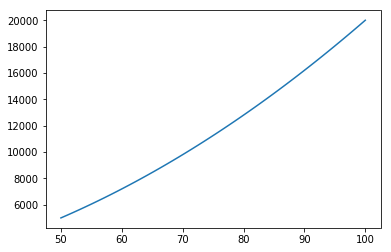

In [33]:
pg = PlotGraph()
pg.test()